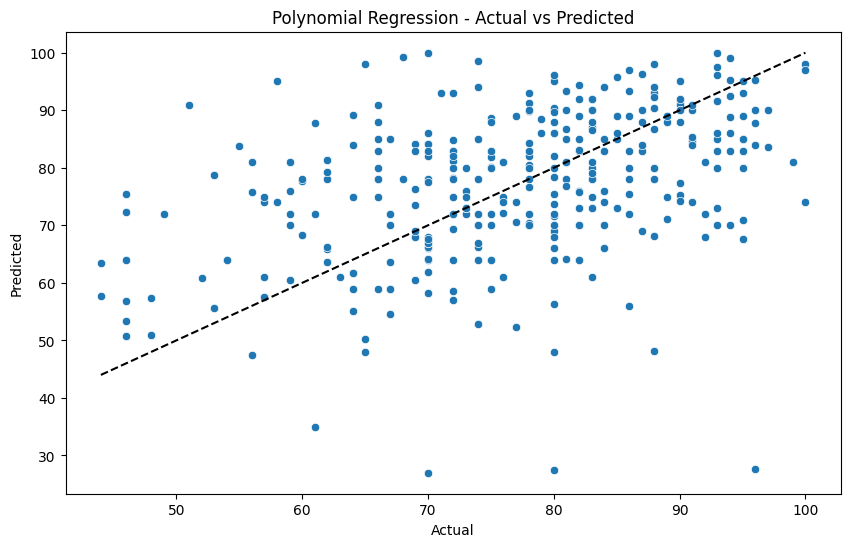

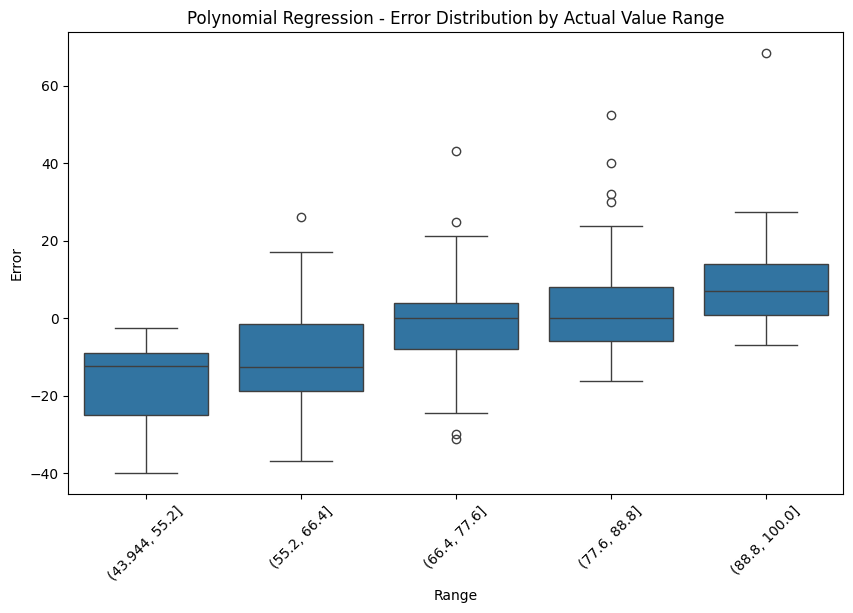

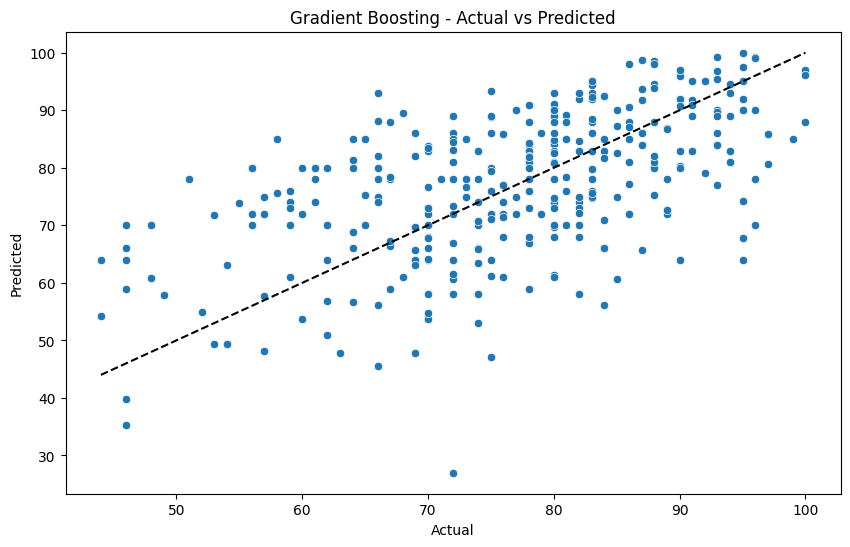

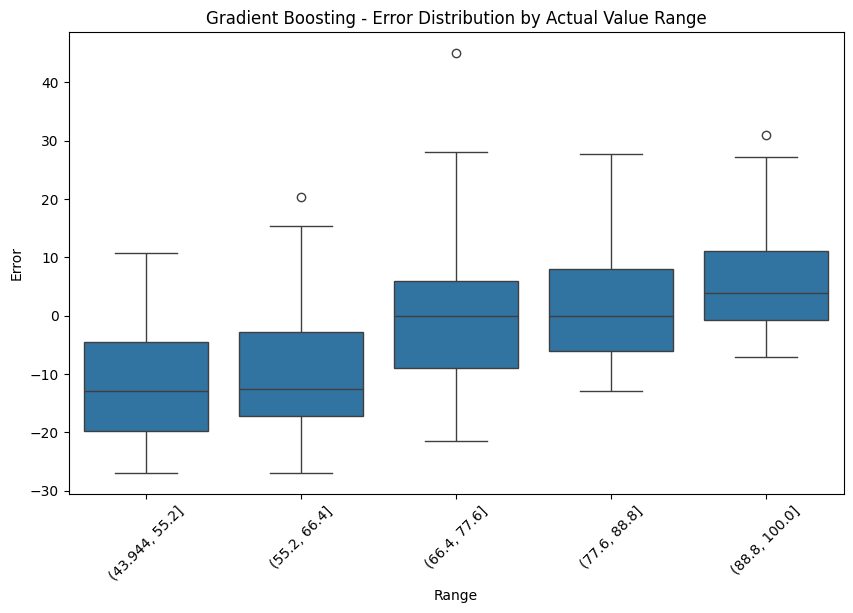

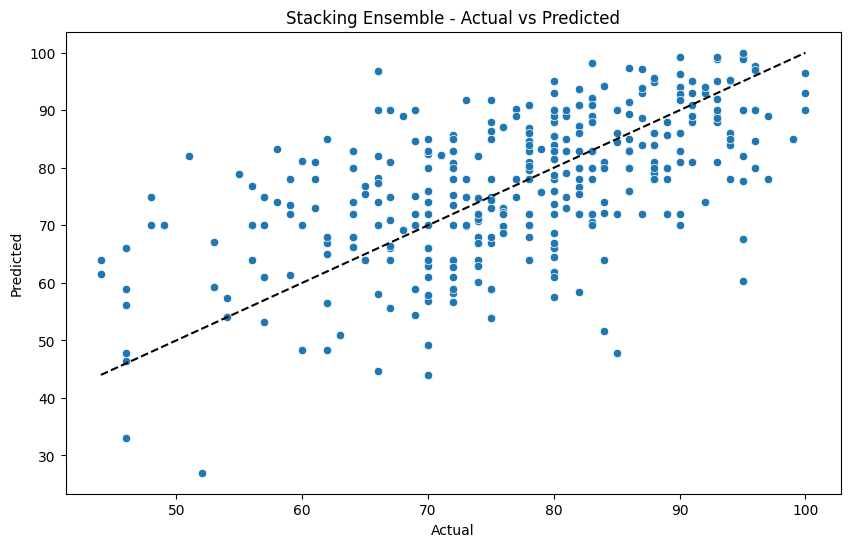

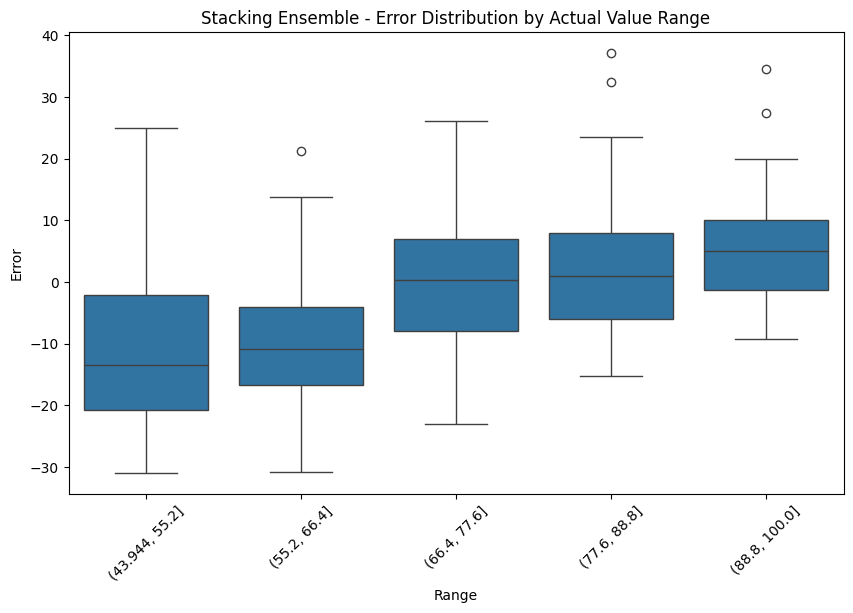

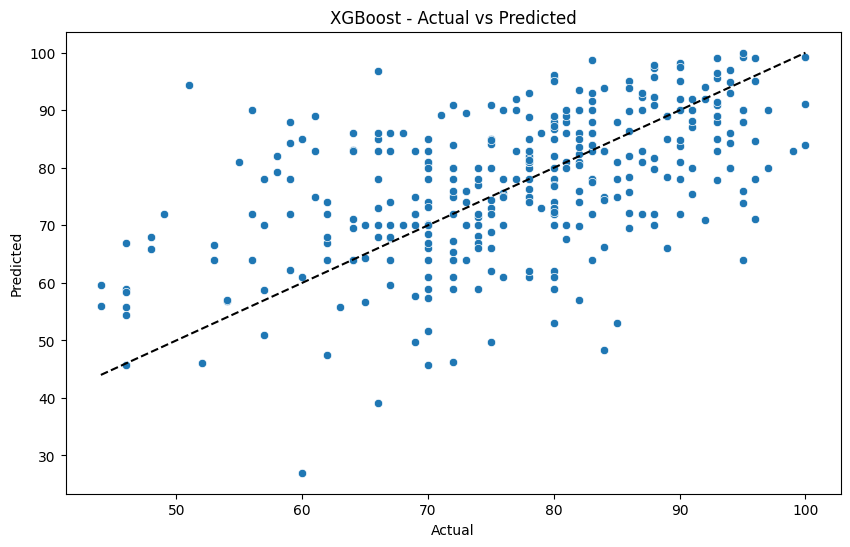

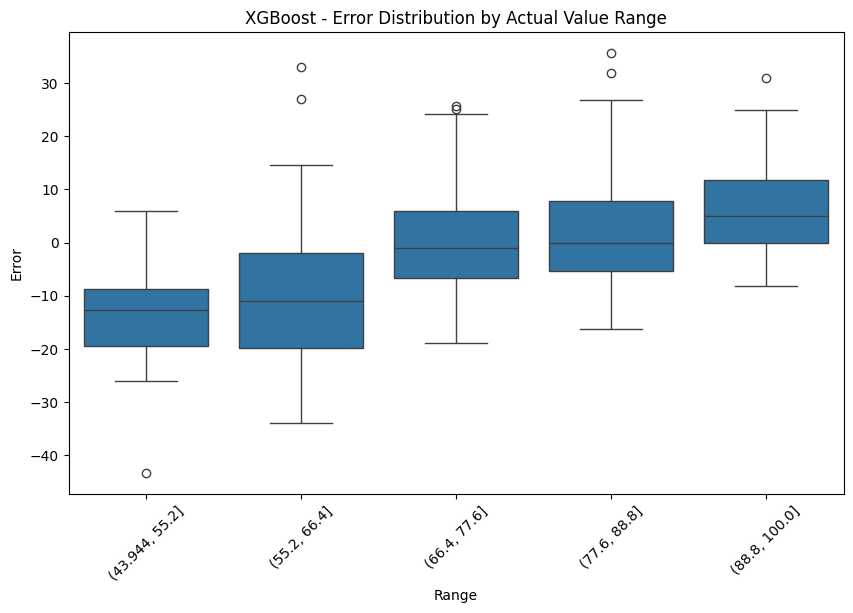


Сравнение моделей:
                   Model        R2        MAE       RMSE  Max Error
2      Stacking Ensemble  0.138926   8.995170  11.275882  37.105028
1      Gradient Boosting  0.134610   8.978065  11.304104  45.000000
3                XGBoost  0.036317   9.161924  11.928816  43.415736
0  Polynomial Regression -0.230176  10.164615  13.477642  68.365511


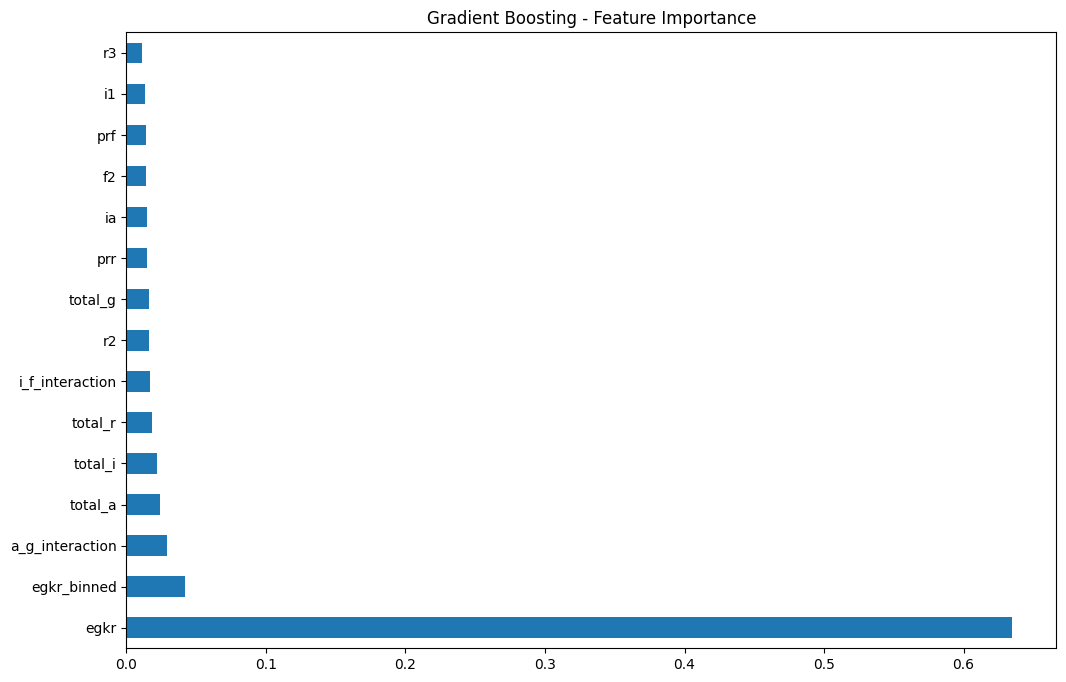

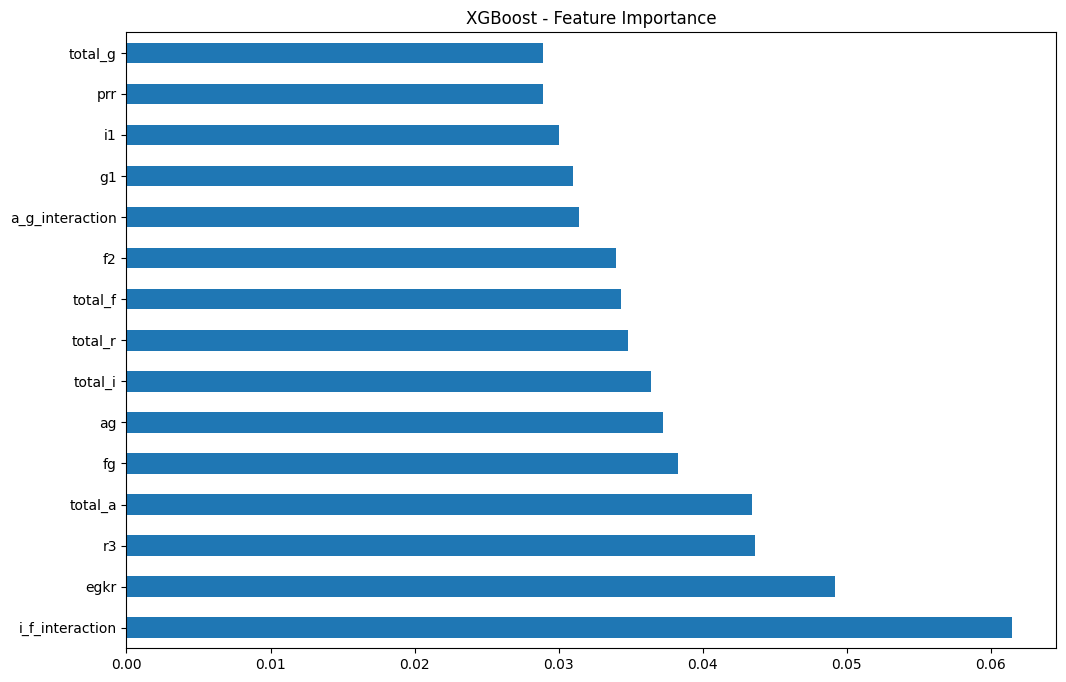

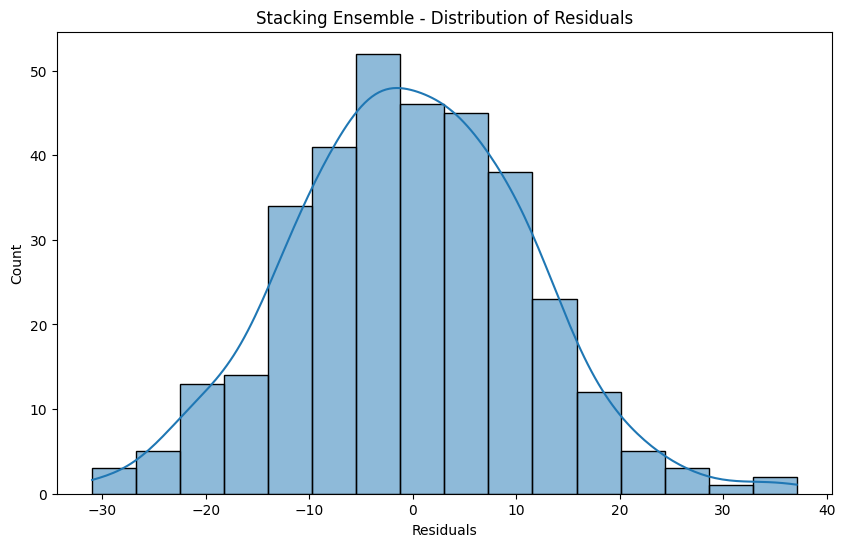

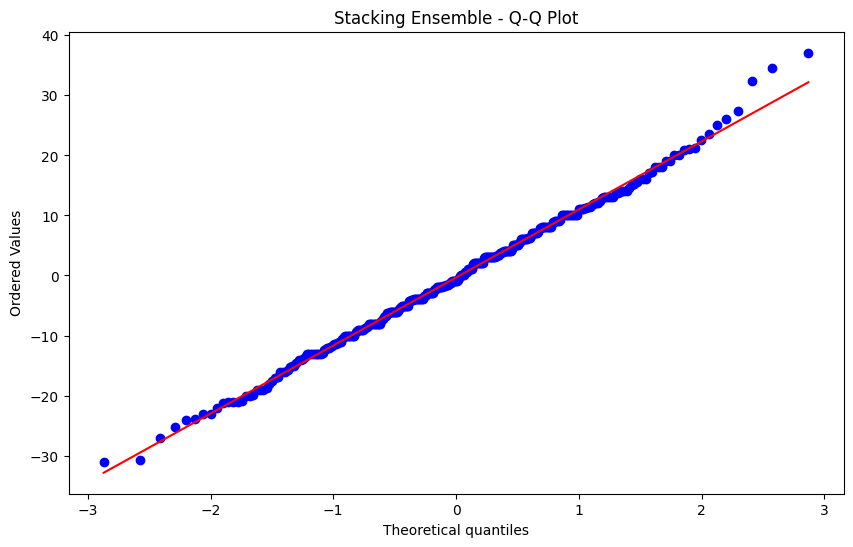

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, max_error
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from xgboost import XGBRegressor
from sklearn.svm import SVR

# Улучшенный пайплайн моделирования
def build_advanced_models():
    # 1. Ансамбль моделей
    base_models = [
        ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
        ('xgb', XGBRegressor(random_state=42)),
        ('svr', SVR(kernel='rbf'))
    ]
    
    stacking_model = StackingRegressor(
        estimators=base_models,
        final_estimator=LinearRegression()
    )
    
    # 2. Пайплайн с предобработкой
    models = {
        "Polynomial Regression": Pipeline([
            ('poly', PolynomialFeatures(degree=2)),
            ('scaler', StandardScaler()),
            ('lr', LinearRegression())
        ]),
        "Gradient Boosting": GradientBoostingRegressor(
            n_estimators=200, learning_rate=0.05, random_state=42
        ),
        "Stacking Ensemble": stacking_model,
        "XGBoost": XGBRegressor(
            n_estimators=300, max_depth=5, learning_rate=0.1, random_state=42
        )
    }
    
    return models

def preprocess_data(df):
    # 1. Более сложная обработка пропусков
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            # Для категориальных признаков используем моду
            if df[col].nunique() < 10:
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                # Для числовых - медиану с группировкой по ball
                df[col] = df.groupby('ball')[col].transform(lambda x: x.fillna(x.median()))
    
    # 2. Генерация новых признаков
    df['total_a'] = df[['a1', 'a2', 'a3']].mean(axis=1)
    df['total_g'] = df[['g1', 'g2', 'g3']].mean(axis=1)
    df['total_i'] = df[['i1', 'i2', 'i3']].mean(axis=1)
    df['total_f'] = df[['f1', 'f2', 'f3']].mean(axis=1)
    df['total_r'] = df[['r1', 'r2', 'r3']].mean(axis=1)
    
    # 3. Взаимодействия признаков
    df['a_g_interaction'] = df['ag'] * df['gg']
    df['i_f_interaction'] = df['ig'] * df['fg']
    
    # 4. Биннинг непрерывных признаков
    df['egkr_binned'] = pd.cut(df['egkr'], bins=5, labels=False)
    
    # 5. Логарифмирование целевой переменной (если распределение skewed)
    if np.abs(df['ball'].skew()) > 1:
        df['ball_log'] = np.log1p(df['ball'])
    
    return df

def postprocess_predictions(y_pred, y_train):
    # 1. Округление до ближайшего реального значения из train
    unique_values = np.sort(y_train.unique())
    y_pred_rounded = np.array([unique_values[np.argmin(np.abs(unique_values - val))] for val in y_pred])
    
    # 2. Калибровка предсказаний
    q_train = np.percentile(y_train, np.linspace(0, 100, 101))
    q_pred = np.percentile(y_pred, np.linspace(0, 100, 101))
    y_pred_calibrated = np.interp(y_pred, q_pred, q_train)
    
    # 3. Ограничение диапазона
    y_pred_final = np.clip(y_pred_calibrated, y_train.min(), y_train.max())
    
    return y_pred_final

def advanced_model_analysis(models, X_train, X_test, y_train, y_test):
    results = []
    
    for name, model in models.items():
        # Обучение модели
        model.fit(X_train, y_train)
        
        # Предсказания
        y_pred = model.predict(X_test)
        
        # Постобработка
        y_pred_processed = postprocess_predictions(y_pred, y_train)
        
        # Метрики
        metrics = {
            'Model': name,
            'R2': r2_score(y_test, y_pred_processed),
            'MAE': mean_absolute_error(y_test, y_pred_processed),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_pred_processed)),
            'Max Error': max_error(y_test, y_pred_processed)
        }
        results.append(metrics)
        
        # Визуализация
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=y_test, y=y_pred_processed)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
        plt.title(f'{name} - Actual vs Predicted')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()
        
        # Ошибки по диапазонам
        error_df = pd.DataFrame({'Actual': y_test, 'Error': y_test - y_pred_processed})
        error_df['Range'] = pd.cut(error_df['Actual'], bins=5)
        
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Range', y='Error', data=error_df)
        plt.title(f'{name} - Error Distribution by Actual Value Range')
        plt.xticks(rotation=45)
        plt.show()
    
    # Сравнительная таблица метрик
    results_df = pd.DataFrame(results)
    print("\nСравнение моделей:")
    print(results_df.sort_values('R2', ascending=False))
    
    # Feature importance для tree-based моделей
    for name, model in models.items():
        if hasattr(model, 'feature_importances_'):
            plt.figure(figsize=(12, 8))
            feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
            feat_importances.nlargest(15).plot(kind='barh')
            plt.title(f'{name} - Feature Importance')
            plt.show()
        elif hasattr(model, 'coef_'):
            plt.figure(figsize=(12, 8))
            coef = pd.Series(model.coef_, index=X_train.columns)
            coef.abs().nlargest(15).plot(kind='barh')
            plt.title(f'{name} - Feature Coefficients (absolute values)')
            plt.show()
    
    return results_df

# Основной пайплайн
df = pd.read_csv("super_new_dataset.csv", sep=';')

# Улучшенная предобработка
df = preprocess_data(df)

# Разделение данных
X = df.drop(columns=["hash", "ball"])
y = df["ball"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Построение и оценка моделей
models = build_advanced_models()
results = advanced_model_analysis(models, X_train, X_test, y_train, y_test)

# Анализ остатков лучшей модели
best_model_name = results.iloc[results['R2'].idxmax()]['Model']
best_model = models[best_model_name]
y_pred = postprocess_predictions(best_model.predict(X_test), y_train)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title(f'{best_model_name} - Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

# Q-Q plot для проверки нормальности остатков
from scipy import stats
plt.figure(figsize=(10, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title(f'{best_model_name} - Q-Q Plot')
plt.show()